In [1]:
import os
import sys
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset

In [4]:
%matplotlib notebook

#### Functions

In [6]:
# get event triggered firing rates USING find_nearest_ind
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate) * 1000 # puts time axis in ms
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [7]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

#### All subjects, bad channels

In [8]:
multisub_bad_chs = {
    '521885': [6,11,12,13,14],
    '521886': [10,11,12,13,14,15,16,17,18],
    '521887': [4,7,11,12,13,14,18],
    '543393': [11,12,13,14],
    '543394': [11,12,13,14,15,17,18,19,20],
    '543395a': [13],
    '543395b': [13],
    '543396a': [4,5,7,8,10,11,12,13,14],
    '543396b': [4,5,7,8,10,11,12,13,14],
}

### Define data path

In [9]:
rec_folder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.


In [10]:
plot_probe = 'probeB'

In [11]:
bad_chs = multisub_bad_chs['543396b']

#### Load stim table

In [12]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,biphasic,80,33.63939,33.63999,0.0004,0
1,biphasic,80,37.74180,37.74240,0.0004,0
2,biphasic,80,41.50520,41.50580,0.0004,0
3,biphasic,80,45.65971,45.66031,0.0004,0
4,biphasic,80,49.84935,49.84996,0.0004,0


#### Parameters for plotting

In [13]:
plot_before = 1.5 # time before event, s
plot_after = 1.5 # time after event, s
plot_event = 'stim' # 'spont' or 'stim'

## if plot_event == 'spont'
spont_time = 0.45 # time in minutes to plot around if spont is chosen

## if plot_event == 'stim'
event_ind = 20 # stim_event time to choose, must be integer
stim_type = 'biphasic' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = '80' # current amplitude = [20, 50, 70, 100]
stim_sweep = 0 # look at an event during chosen sweep, int between 0 and 9?

In [14]:
if plot_event == 'spont':
    plot_time = spont_time*60 # this value should be in seconds now
elif plot_event == 'stim':
    stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
    plot_time = stim_times[event_ind] # this value should be in seconds
print('Plot time: %0.2f s' % plot_time)

Plot time: 113.98 s


In [15]:
with open(exp.ephys_params[plot_probe]['probe_info']) as data_file:
    data = json.load(data_file)
npx_allch = np.array(data['channel'])
surface_ch = int(data['surface_channel'])
allch_z = np.array(data['vertical_pos'])
ref_mask = np.array(data['mask'])
print(surface_ch)

npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
npx_ch_depths = allch_z[surface_ch] - allch_z[npx_chs]

220


### LFP plot all channels

In [16]:
rawmm = np.memmap(exp.ephys_params[plot_probe]['lfp_continuous'], dtype='int16', mode='r')
lfp_data_mm = np.reshape(rawmm, (int(rawmm.size/exp.ephys_params[plot_probe]['num_chs']), exp.ephys_params[plot_probe]['num_chs']))
lfp_ts = np.load(exp.ephys_params[plot_probe]['lfp_timestamps'])

# have npx_chs and npx_ch_depths from above
# also need to use the exp.NPX_lfp_channel_order to reorder LFP chs
# a recent Npx slack ch convo Josh says to use 0.195 regardless of gain (Oct 2020)

In [17]:
if plot_event == 'spont':
    plot_inds = np.squeeze(np.argwhere((lfp_ts > plot_time-plot_before) & (lfp_ts < plot_time+plot_after)))
    lfp_traces = lfp_data_mm[plot_inds,:][:,exp.NPX_lfp_channel_order[npx_chs]] * exp.ephys_params[plot_probe]['bit_volts']
    lfp_xaxis = lfp_ts[plot_inds]
elif plot_event == 'stim':
    plot_inds = np.squeeze(np.argwhere((lfp_ts > plot_time-plot_before) & (lfp_ts < plot_time+plot_after)))
    lfp_traces = lfp_data_mm[plot_inds,:][:,exp.NPX_lfp_channel_order[npx_chs]] * exp.ephys_params[plot_probe]['bit_volts']
    lfp_xaxis = lfp_ts[plot_inds] - plot_time

#### Some filtering fun!

### High pass filter

In [18]:
lfp_highpass = remove_lfp_offset(lfp_traces, exp.ephys_params[plot_probe]['lfp_sample_rate'], 0.5, 3)

<IPython.core.display.Javascript object>


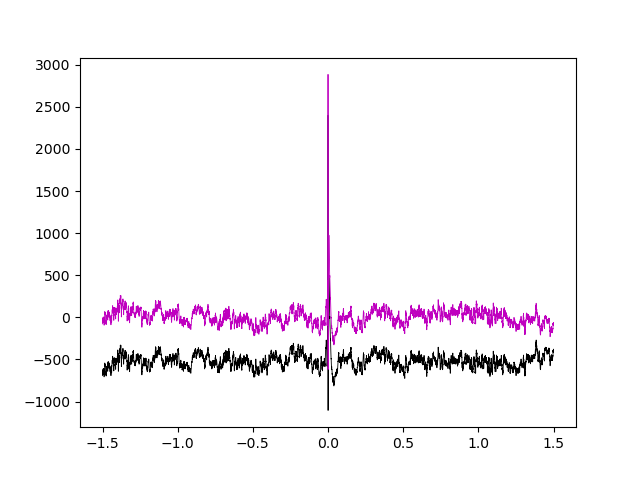

In [19]:
pch = 3

fig, ax = plt.subplots()
ax.plot(lfp_xaxis, lfp_traces[:,pch], 'k', linewidth=0.6)
ax.plot(lfp_xaxis, lfp_highpass[:,pch], 'm', linewidth=0.6)

### Low pass filter

<IPython.core.display.Javascript object>


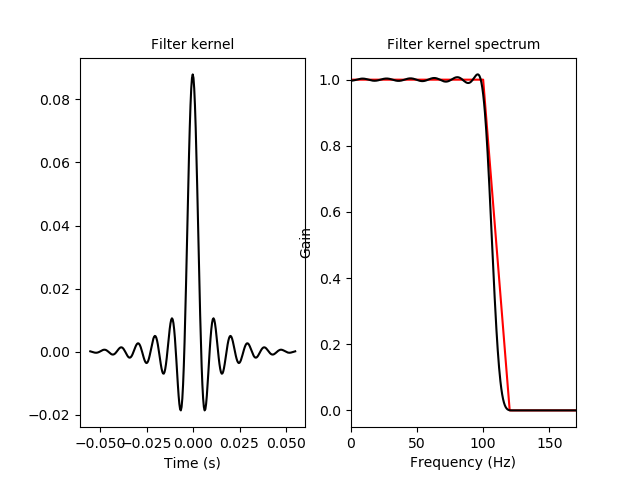

In [20]:
# design and check the lowpass filter kernel
filter_kernel = lowpass_filt_design(len(lfp_xaxis),
                                    exp.ephys_params[plot_probe]['lfp_sample_rate'],
                                    cutoff_freq=100,
                                    trans_width=0.2,
                                    order_multiple=11,
                                    plot_kern=True)

In [21]:
start = time.time()
# apply filter to notch filtered data
lfp_bandpass = signal.filtfilt(filter_kernel, 1, lfp_highpass, axis=0)
end = time.time()
print('Time to filter: %0.2f s' % (end-start))

Time to filter: 0.60 s


<IPython.core.display.Javascript object>


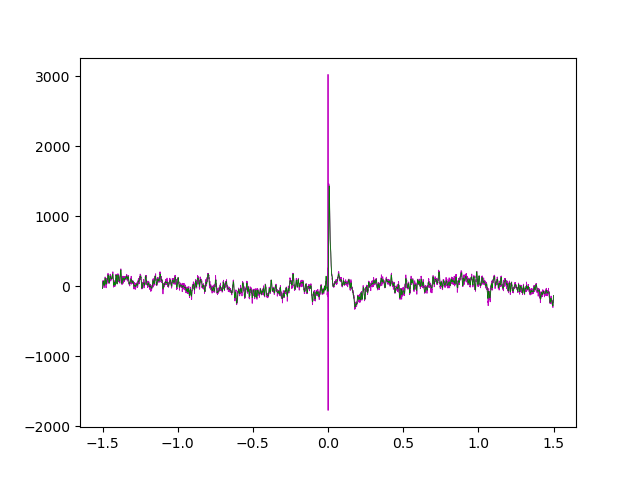

In [23]:
pch = 180

fig, ax = plt.subplots()
ax.plot(lfp_xaxis, lfp_highpass[:,pch], 'm', linewidth=0.6)
ax.plot(lfp_xaxis, lfp_bandpass[:,pch], 'g', linewidth=0.6)

Plot chs as heat map

<IPython.core.display.Javascript object>


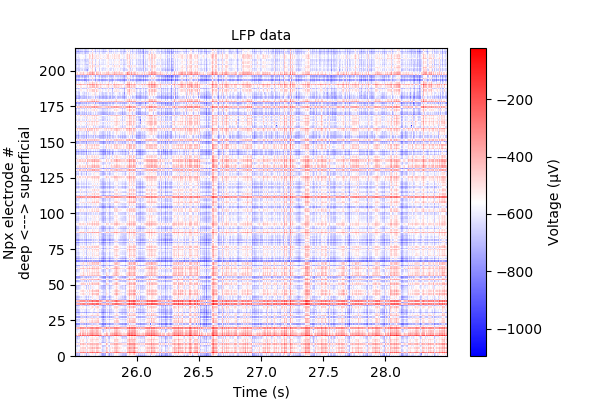

In [136]:
set_vrange = 400 # microvolts

fig, ax = plt.subplots(figsize=(6,4))
lfp_plot = ax.imshow(lfp_traces.T,
                     cmap='bwr',
                     aspect='auto',
                     origin='lower',
#                             vmin=-set_vrange,
#                             vmax=set_vrange,
                     extent=[lfp_xaxis[0], lfp_xaxis[-1], 0, len(npx_chs)],
                    )
# ax.set_yticks(np.arange(len(npx_chs))+0.5)
# ax.set_yticklabels(npx_chs, fontsize=8)
ax.set_title('LFP data')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Npx electrode #\ndeep <---> superficial')
cbar = plt.colorbar(lfp_plot)
cbar.set_label('Voltage (\u03BCV)')
    
    # Save plots?
#     plot_title = ('Ramp_avg_evoked_traces_%duA.png' % ampi)
#     plt.savefig(os.path.join(plotsavedir, plot_title), format='png')